# La più semplice rete neurale per trovare la retta che meglio modella un insieme di punti (x,y)
Luca Mari, marzo 2023  

[i file di questa attività: [linear.ipynb](linear.ipynb), [linearutils.py](linearutils.py)]

**Obiettivi**: comprendere il funzionamento di base di una semplice rete neurale, per come specificato in Python mediante un modulo di alto livello come `PyTorch`.  
**Precompetenze**: basi di Python.

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente
    * copiare nella cartella questo notebook e aprirlo
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch matplotlib ipympl`

Supponiamo di disporre di un insieme di dati $(x_i, y_i)$, e da questo di voler costruire una funzione $f$ in grado di prevedere un $y$ per ogni $x$ dato, dunque tale che $y = f(x)$. Per ogni $x_i$, indicheremo dunque con $y_i$ il dato nel training set e con $\hat y_i$ il valore previsto dal modello.

Ipotizziamo che il modello $f$ da costruire sia una funzione lineare, dunque geometricamente una retta $y = k_0 + k_1 x$, così che il modello è una funzione a due parametri, $y = f_{k_0, k_1}(x)$, di cui occorre stimare i valori: si tratta di un problema noto in statistica come *regressione lineare*.

Il problema è così semplice che potrebbe essere risolto per via analitica, con il metodo dei minimi quadrati. Noi lo risolveremo però per via numerica, costruendo una semplice rete neurale, da addestrare mediante il *training set* $\{(x_i, y_i)\}$.

Importiamo prima di tutto i moduli Python necessari.

In [24]:
%matplotlib widget
from linearutils import get_params, plot
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Costruiamo il *training set*, che supponiamo generato dalla sovrapposizione di valori disposti su una retta e di valori casuali estratti da una distribuzione normale standard, dunque a media 0 e deviazione standard 1, e quindi rappresentiamolo graficamente.

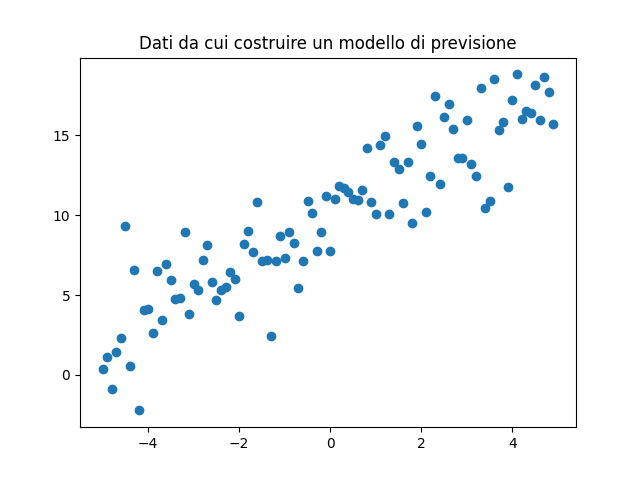

In [25]:
z0, z1 = 10, 1.5                # i valori veri, e supposti ignoti e da stimare, dei parametri della retta e dunque del modello

x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = z0 + z1 * x + 2 * torch.randn(x.size())

plot(x, y, 'Dati da cui costruire un modello di previsione')

Costruiamo una rete neurale con un neurone di input e uno di output, per *x* e *y* rispettivamente, che avrà dunque due parametri, $k_0$ e $k_1$, corrispondenti all'intercetta della retta (il bias) e alla pendenza della retta (il "peso" della connessione). I valori iniziali di $k_0$ e $k_1$ sono casuali, e quindi la retta di regressione non ha alcuna affidabilità. 

[-0.0, 0.59]


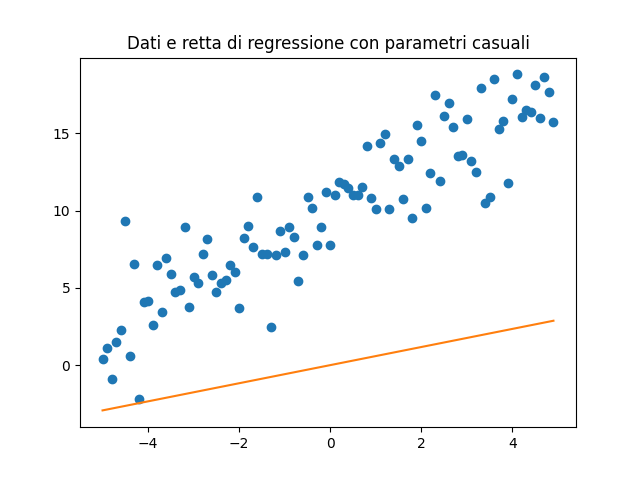

In [28]:
model = torch.nn.Linear(1, 1)

print(get_params(model, 2))
plot(x, y, 'Dati e retta di regressione con parametri casuali', model)

Scegliamo come addestrare la rete specificando:
* l'iperparametro tasso di apprendimento (*learning rate*, lr);
* l'iperparametro numero di epoche;
* il criterio per valutare la qualità delle previsioni, in questo caso l'errore quadratico medio (*mean squared error*, MSE);
* il metodo di ottimizzazione, in questo caso la *back propagation* mediante discesa stocastica lungo il gradiente (*stochastic gradient descent*, SGD).

In [29]:
lr = 0.1
num_epochs = 10
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

Addestriamo la rete, visualizzando stimati dei valori dei parametri in ogni epoca, e alla fine il grafico con la retta di regressione risultante.

1 [1.98, 2.1]
2 [3.58, 1.11]
3 [4.84, 1.78]
4 [5.87, 1.35]
5 [6.68, 1.65]
6 [7.33, 1.46]
7 [7.85, 1.59]
8 [8.27, 1.51]
9 [8.61, 1.57]
10 [8.87, 1.53]


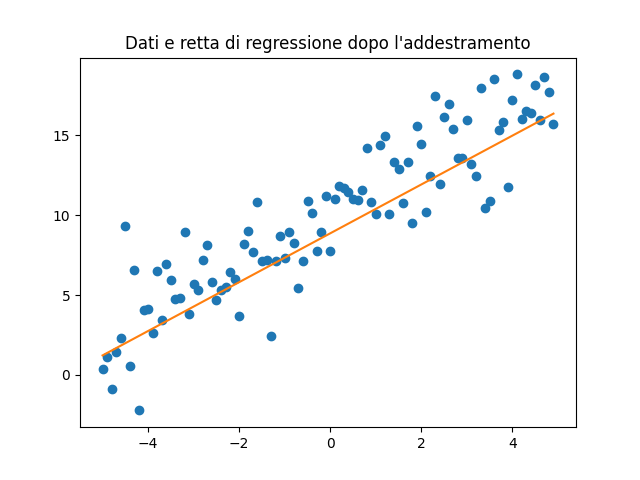

In [30]:
for epoch in range(num_epochs):
    y1 = model(x)
    loss = criterion(y1, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(epoch+1, get_params(model, 2))

plot(x, y, "Dati e retta di regressione dopo l'addestramento", model)

Possiamo ottenere un risultato analogo visualizzando la retta di regressione alla fine di ogni epoca, per mostrare la convergenza progressiva verso la retta che meglio stima quella da cui i dati nel *training set* sono stati generati (il codice Python qui sotto contiene vari dettagli concettualmente non così rilevanti).

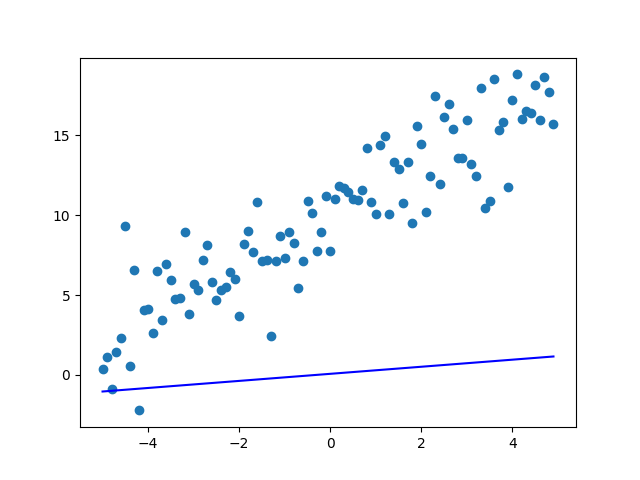

In [31]:
model = torch.nn.Linear(1, 1)
lr = 0.05
num_epochs = 50
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

plt.close('all')
xx, yy = x.numpy(), y.numpy()
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(xx, yy, marker='o')
[k0, k1] = get_params(model)
line, = ax.plot(xx, k0 + k1 * xx, color='blue')

def update(epoch):
    y1 = model(x)
    loss = criterion(y1, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    mse = torch.mean((y1 - y)**2)
    line.set_ydata(y1.detach().numpy())
    plt.title(f'epoca = {epoch+1},   MSE={mse:.2f}')
    return line,

_ = FuncAnimation(fig, update, frames=num_epochs, interval=100, repeat=False)
plt.show()
